<center>

# **TRỰC QUAN HÓA DỮ LIỆU**

## **Lab 1<br>Mối quan hệ của dữ liệu<br>Nhóm 6 - 20KHDL-MMT-CNTT**

</center>

<center>

# **Thành viên nhóm**

| Mã số sinh viên |     Họ và tên      |
|-----------------|--------------------|
|20127130         | Bùi Tiến Đạt       |
|20127443         | Nguyễn Hồ Hữu Bằng |
|20127612         | Đỗ Khánh Sang      |
|20127613         | Phan Thanh Sang    |
|20127684         | Mai Trần Khánh Duy |

</center>

<center>

# **Mục lục** <a name = "TOC"></a>

</center>

- [1. Các thư viện sử dụng](#section1)
- [2. Mô tả tập dữ liệu](#section2)
- [3. Các hàm tự định nghĩa](#section3)
- [4. Thu thập dữ liệu](#section4)
- [5. Tiền xử lý dữ liệu](#section5)
- [6. Trực quan hóa dữ liệu](#section6)
    - [6.1. Mật độ ca nhiễm covid của các nước trên toàn cầu vào ngày 01/03/2023](#section6_1)
    - [6.2. Mối quan hệ giữa tổng số ca nhiễm và tổng số lượt test của các nước vào ngày 01/03/2023](#section6_2)
    - [6.3. Mối quan hệ giữa tổng số ca nhiễm và tổng số ca chết của các nước vào ngày 01/03/2023](#section6_3)
    - [6.4. Tỉ lệ số ca nhiễm và tỉ lệ dân số giữa các vùng trên thế giới vào ngày 01/03/2023](#section6_4)
    - [6.5. Số ca mắc mới, ca chết mới và ca hồi phục mới qua từng ngày của 3 nước Nhật Bản, Đài Loan và Nga từ ngày 01/03/2023 đến ngày 07/03/2023](#section6_5)
    - [6.6. Tỉ lệ giữa số ca chết, số ca hồi phục và số ca đang nhiễm bệnh trên tổng số ca của các vùng trên thế giới vào ngày 01/03/2023](#section6_6)
- [7. Tài liệu tham khảo](#section7)

# **1. Các thư viện sử dụng** <a name = "section1"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

from datetime import datetime


---

# **2. Mô tả tập dữ liệu** <a name = "section2"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

- Tập dữ liệu được thu thập từ trang web https://www.worldometers.info/coronavirus/ do Tổ chức Worldometer quản lý. Nhìn chung, tập dữ liệu gồm các trường dữ liệu liên quan đến số liệu của tình hình dịch bệnh covid của các quốc gia và vùng lãnh thổ trên toàn thế giới.
- Tập dữ liệu có 231 dòng và 15 cột. Qua việc khai thác, khám phá và trực quan hóa dữ liệu, nhóm sẽ từ từ hé lộ và đưa ra những thông tin rút trích được về tình hình diễn biến của 1 trong những dịch bệnh nguy hiểm nhất lịch sử nhân loại tính đến hiện nay.
- Số liệu ở đây chỉ được thu thập kể từ ngày 01/03/2023 cho nên không thể bao quát được toàn bộ diễn biến dịch bệnh kể từ khi bùng phát lần đầu tiên trên toàn cầu, nhưng nhóm sẽ cố gắng đưa ra được 1 cái nhìn tổng quan và khách quan nhất hết sức có thể.

---

# **3. Các hàm tự định nghĩa** <a name = "section3"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [321]:
# Convert string to datetime
def convert_to_date(dt):
    dt = dt.split()[2:5]
    dt = ' '.join(dt).strip(',')
    dt = datetime.strptime(dt, '%B %d, %Y').date()
    return dt

# Process raw data from original rows collected from website
def process_data(rows):
    rows = [rows[i].split('\n') for i in range(len(rows))]
    rows = [rows[i] for i in range(len(rows)) if len(rows[i]) == 19]
    rows = [rows[i][2:17] for i in range(len(rows))]
    rows = [[rows[i][j].strip() for j in range(len(rows[i]))] for i in range(len(rows))]
    rows = np.array(rows)
    return rows

# Collect data from website
def collect_data():
    url = 'https://www.worldometers.info/coronavirus/'
    driver = webdriver.Chrome()
    driver.get(url)

    # get page source
    pgsrc = BeautifulSoup(driver.page_source)

    # get date
    find_date = driver.find_element(By.XPATH, '/html/body/div[3]/div[2]/div[1]/div/div[2]')
    dt = find_date.text
    dt = convert_to_date(dt)

    # get odd and even data rows
    find_odd_rows = pgsrc.find_all('tr', class_ = 'odd')
    find_even_rows = pgsrc.find_all('tr', class_ = 'even')

    odd_rows = [find_odd_rows[i].get_text() for i in range(len(find_odd_rows))]
    even_rows = [find_even_rows[i].get_text() for i in range(len(find_even_rows))]

    # process raw data rows
    odd_rows = process_data(odd_rows)
    even_rows = process_data(even_rows)

    # only take data of the current day, not the yesterday and the day after yesterday
    odd_rows = odd_rows[:len(odd_rows)//3]
    even_rows = even_rows[:len(even_rows)//3]

    # concatenate odd rows and even rows
    covid_data = np.concatenate((odd_rows, even_rows), axis = 0)

    driver.quit()

    return dt, covid_data

# Create dataframe and save into memory
def create_df(covid_data, dt):
    col_name = ['Country', 'Total_cases', 'New_cases', 'Total_deaths', 'New_Deaths', 'Total_recovered', 'New_recovered', 'Active_cases', 'Serious_critical', 'Cases/1Mpop', 'Deaths/1Mpop', 'Total_tests', 'Tests/1Mpop', 'Population', 'Area']
    covid_df = pd.DataFrame(data=covid_data, columns=col_name)
    
    file_name = 'datasets/' + dt.strftime('%d-%m-%Y') + '-raw.csv'
    covid_df.to_csv(file_name, index=False, encoding='utf-8')

    return covid_df

# Preprocess data, adjust inproper data fields
def preprocessing(covid_df, dt):
    obj_cols = covid_df.select_dtypes(include=['object']).columns
    for obj_col in obj_cols[1:-1]:
        covid_df[obj_col] = pd.to_numeric(covid_df[obj_col].str.replace('[^\d-]', '', regex=True))

    covid_df['Area'] = covid_df['Area'].replace('', 'Other')
    covid_df = covid_df.sort_values(['Total_cases'], ascending=False).reset_index(drop=True)
    file_name = 'datasets/' + dt.strftime('%d-%m-%Y') + '.csv'
    covid_df.to_csv(file_name, index=False, encoding='utf-8')

    return covid_df


---

# **4. Thu thập dữ liệu** <a name = "section4"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [322]:
'''Uncomment these code lines to collect data of the current day'''

# dt, covid_data = collect_data()
# covid_df = create_df(covid_data, dt)
# covid_df

'Uncomment these code lines to collect data of the current day'

---

# **5. Tiền xử lý dữ liệu** <a name = "section5"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [323]:
'''Uncomment these code lines and those lines of the above cell to collect and preprocess data of the current day'''

# covid_df = preprocessing(covid_df, dt)
# covid_df

'Uncomment these code lines and those lines of the above cell to collect and preprocess data of the current day'

---

# **6. Trực quan hóa dữ liệu** <a name = "section6"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

### **6.1. Mật độ ca nhiễm covid của các nước trên toàn cầu vào ngày 01/03/2023** <a name = "section6_1"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [324]:
fc = '#F7F8F3' # figure color
bg = '#F3ECD8' # background color
c1 = '#F7444E' # color 1
c2 = '#78BCC4' # color 2
ec = '#002C3E' # edge color

cv_df = pd.read_csv('datasets/01-03-2023.csv')

In [325]:
fig = px.choropleth(cv_df, 
                    locations='Country', 
                    locationmode='country names',
                    color='Total_cases',
                    color_continuous_scale='peach',
                    range_color=(0, cv_df['Total_cases'].max()),
                    labels={'Total_cases': 'Total Cases'},
                    title='Choropleth Map of Total Cases by Country'
                   )
fig.update_layout(margin=dict(l=50, r=50, t=50, b=50))
fig.show()

- Nhận xét:

    - Theo thống kê của https://www.worldometers.info/coronavirus ngày 1-3-2023:
        + Khi nhìn vào biểu đồ nước có nhiều ca nhiễm nhất là USA với hơn 100 triệu ca.
        + Ở Châu Mỹ, trừ USA, nước Brazil, Argentina và Mexico là các nước có ca nhiễm nhiều tiếp theo thứ tự giảm dần.
        + Ở Châu Phi đa số các nước đều nhạt màu cho thấy ca lây nhiễm đều dưới ngưỡng 1 triệu ca trừ Morocco và Nam Phi lần lượt là khoảng 1,2 triệu và 4 triệu ca.
        + Các nước Châu Âu như Anh, Pháp, Đức, Ý, Tây Ban Nha nằm cạnh nhau dẫn đến sự lây lan và các nước đều có ca nhiễm từ 10-20 triệu ca.
        + Ở phía Đông Châu Á, 2 nước có ca nhiễm nhiều nhất là Nhật Bản và Hàn Quốc, tuy diện tích nước nhỏ nhưng dân số đông dẫn đến tình trạng ca nhiễm rất cao (khoảng 30 triệu)
        + Ở Đông Nam Á ta dễ dàng thấy được Việt Nam là nước có nhiều ca nhiễm nhát lên tới 11 triệu ca.
        + Vùng màu vàng nhạt rộng lớn là Nga với 22 triệu ca, con số này chỉ bằng phân nửa nước Ấn Độ.


---

### **6.2. Mối quan hệ giữa tổng số ca nhiễm và tổng số lượt test của các nước vào ngày 01/03/2023** <a name = "section6_2"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [326]:
cases_tests = cv_df[['Country', 'Total_cases', 'Total_tests']].dropna(subset=['Total_tests'])
cases = cases_tests['Total_cases']

# Remove outlier with IQR
q1, q3 = np.percentile(cases, [25, 75])
print('Q1 =', q1, '\nQ2 =', q3)
IQR = q3 - q1
upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print('\nLower bound =', lower_bound, '\nUpper bound =', upper_bound)

cases_tests = cases_tests[(cases_tests['Total_cases'] > lower_bound) & (cases_tests['Total_cases'] < upper_bound)].reset_index().iloc[:, 1:]
cases = cases_tests['Total_cases']
tests = cases_tests['Total_tests']
cases_tests

Q1 = 34790.0 
Q2 = 1462169.0

Lower bound = -2106278.5 
Upper bound = 3603237.5


,Country,Total_cases,Total_tests
0,Romania,3340342,26676248.0
1,Denmark,3175264,129197382.0
2,Hong Kong,2883453,76127725.0
3,Sweden,2697827,19469139.0
4,Serbia,2492563,12396861.0
...,...,...,...
171,Macao,3514,7850.0
172,Saint Pierre Miquelon,3452,25400.0
173,Wallis and Futuna,3427,20508.0
174,Falkland Islands,1930,8632.0


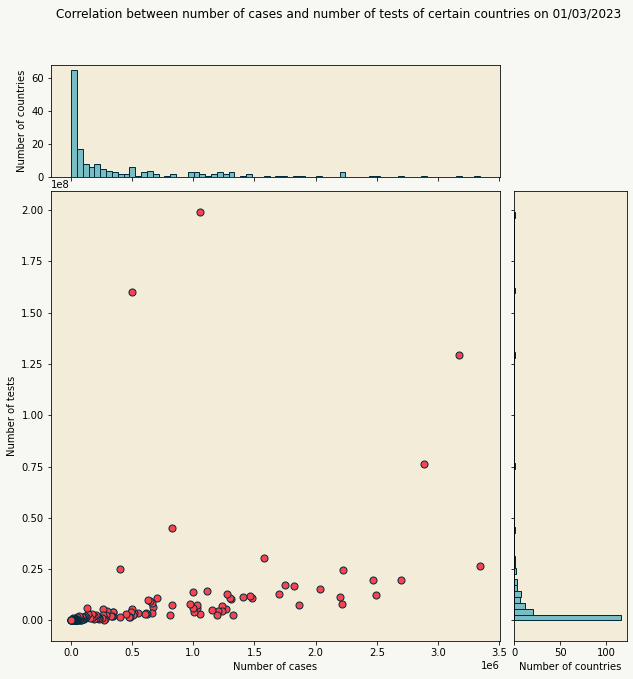

In [327]:
fig = plt.figure(figsize=(10, 10))
fig.set_facecolor(fc)
fig.suptitle('Correlation between number of cases and number of tests of certain countries on 01/03/2023')

gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

ax.set_facecolor(bg)
ax.scatter(cases, tests, color=c1, edgecolors=ec, s=50, )
ax.set_xlabel('Number of cases')
ax.set_ylabel('Number of tests')
ax.set_xlim()

ax_histx.set_facecolor(bg)
ax_histy.set_facecolor(bg)
ax_histx.hist(cases, bins=70, color=c2, edgecolor=ec)
ax_histy.hist(tests, bins=70, orientation='horizontal', color=c2, edgecolor=ec)
ax_histx.set_ylabel('Number of countries')
ax_histy.set_xlabel('Number of countries');

- Nhận xét:

	- Từ biểu đồ ta có thể thấy được vào ngày 01/03/2023, đa số các nước có số ca nhiễm nằm trong phạm vi khoảng từ 0 đến 1.5 triệu ca, trong khi số lượt test là từ 0 đến 200 triệu.
	- Ta có thể thấy được rằng phần lớn nước có số lượt tests càng cao thì số ca nhiễm cũng càng tăng.
	- Tuy nhiên có nhiều nước tuy thực hiện rất nhiều tests nhưng số ca nhiễm nằm ở mức thấp và tương đối.
	
		→ Điều đó cho thấy không phải cứ thực hiện nhiều tests thì số ca nhiễm sẽ cao. Việc này đồng nghĩa rằng 2 trường dữ liệu Total_cases và Total_tests không có mối quan hệ nhân quả.


---

### **6.3. Mối quan hệ giữa tổng số ca nhiễm và tổng số ca chết của các nước vào ngày 01/03/2023** <a name = "section6_3"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

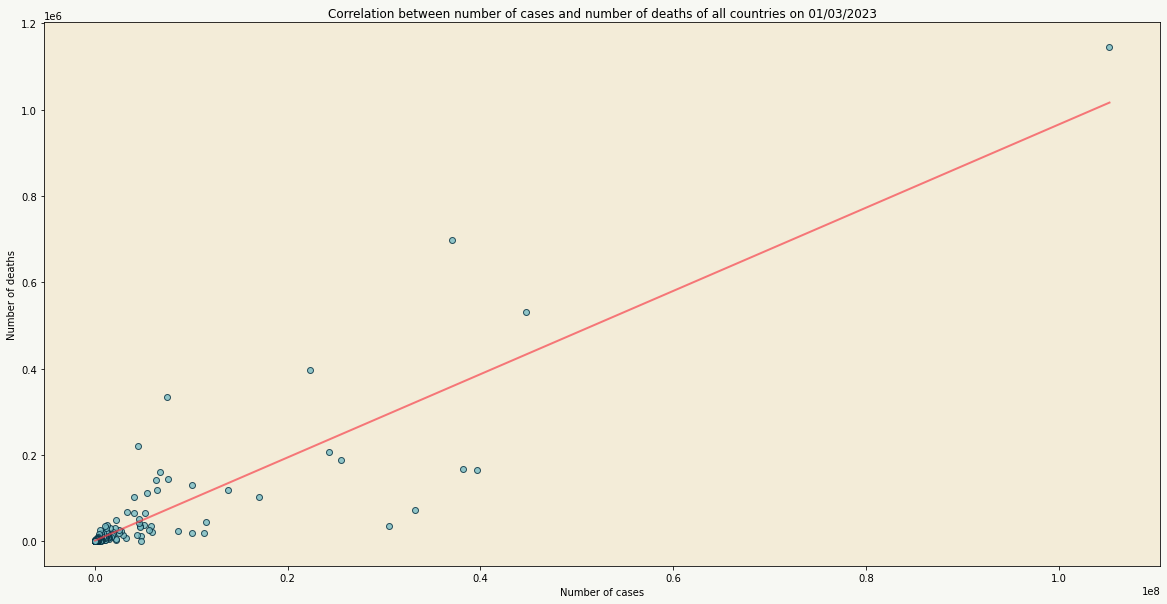

In [328]:
fig = plt.figure(figsize=(20,10))
fig.set_facecolor(fc)

plt.title('Correlation between number of cases and number of deaths of all countries on 01/03/2023')
ax = sns.regplot(x=cv_df["Total_cases"], y=cv_df["Total_deaths"], color=c2,
            line_kws={"color":c1,"alpha":0.7,"lw":2}, scatter_kws={'edgecolor':ec}, ci=None)
ax.set_xlabel('Number of cases')
ax.set_ylabel('Number of deaths')
ax.set_facecolor(bg);

- Nhận xét:

    - Thông qua việc sử dụng ScatterPlot để thống kê mức độ tương quan giữa Tổng số ca nhiễm (Total_cases) và tổng số ca tử vong (Total_deaths) gây ra bởi Covid-19 từ trang https://www.worldometers.info/coronavirus/ , vào ngày 1/3/2023, ta có thể đưa ra 1 số nhận xét về mặt trực quan rằng:
        - Tổng số ca nhiễm và tổng số ca tử vong có mối quan hệ tương quan tầm trung (moderate , positive) và tuyến tính , ở các nước toàn cầu có tổng số ca nhiễm cao thì sẽ có tỉ lệ ca tử vong cũng sẽ cao hơn những nước có tổng số ca nhiễm thấp hơn.
        - Dữ liệu từ ngày 1/3/2023 trong trang thống kê này cũng cho thấy là dữ liệu có mối quan hệ nhân quả , khi mà số ca nhiễm gia tăng thì số ca tử vong cũng phần nào tăng cao , tỷ lệ thuận với số ca nhiễm . Đặc biệt là ở USA , với tổng số ca nhiễm là cao nhất với hơn 105 triệu ca nhiễm thì tổng số ca tử vong cũng là lớn nhất trong các quốc gia , tại 1.145.661 ca tử vong.
        - Đa số các quốc gia có thể thấy được qua ScatterPlot, có tổng ca nhiễm và tổng ca tử vong trung bình đều dưới 20tr cho mỗi loại thông số. 
        - Quốc gia có tổng ca nhiễm/tổng ca tử vong lớn nhất (tính đến ngày 1/3/2023) là USA và thấp nhất là Tokelau với 5 tổng ca nhiễm và 0 ca tử vong 

---

### **6.4. Tỉ lệ số ca nhiễm và tỉ lệ dân số giữa các vùng trên thế giới vào ngày 01/03/2023** <a name = "section6_4"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [329]:
areas = cv_df[['Total_cases', 'Population', 'Area']].groupby(['Area']).sum().sort_values(['Total_cases'], ascending=False)
areas = areas.drop(index='Other')

areas['Cases_proportion'] = (areas['Total_cases'] / areas['Total_cases'].sum() * 100).round(2)
areas['Pop_proportion']   = (areas['Population']  / areas['Population'].sum()  * 100).round(3)
areas

,Total_cases,Population,Cases_proportion,Pop_proportion
Area,,,,
Europe,246314132,7.475438e+08,36.22,9.409
Asia,214353455,4.711357e+09,31.52,59.300
North America,124590104,5.981409e+08,18.32,7.529
South America,68008352,4.376944e+08,10.00,5.509
Australia/Oceania,13996296,4.347041e+07,2.06,0.547
Africa,12794281,1.406729e+09,1.88,17.706


In [330]:
areas = areas.sort_values('Cases_proportion', ascending=False)
cases_label = areas.index
cases_prop = areas['Cases_proportion']
cases_explode = [0.1, 0, 0, 0, 0 ,0]
areas

,Total_cases,Population,Cases_proportion,Pop_proportion
Area,,,,
Europe,246314132,7.475438e+08,36.22,9.409
Asia,214353455,4.711357e+09,31.52,59.300
North America,124590104,5.981409e+08,18.32,7.529
South America,68008352,4.376944e+08,10.00,5.509
Australia/Oceania,13996296,4.347041e+07,2.06,0.547
Africa,12794281,1.406729e+09,1.88,17.706


In [331]:
areas = areas.sort_values('Pop_proportion', ascending=False)
pop_label = areas.index
pop_prop = areas['Pop_proportion']
pop_explode = [0.1, 0, 0, 0, 0 ,0]
areas

,Total_cases,Population,Cases_proportion,Pop_proportion
Area,,,,
Asia,214353455,4.711357e+09,31.52,59.300
Africa,12794281,1.406729e+09,1.88,17.706
Europe,246314132,7.475438e+08,36.22,9.409
North America,124590104,5.981409e+08,18.32,7.529
South America,68008352,4.376944e+08,10.00,5.509
Australia/Oceania,13996296,4.347041e+07,2.06,0.547


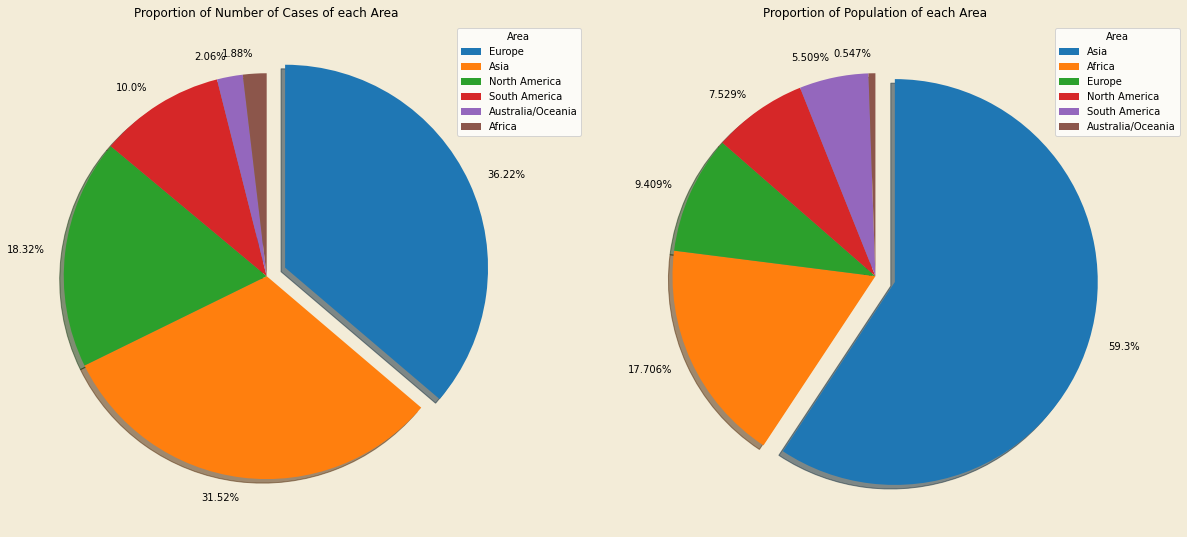

In [332]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
fig.set_facecolor(bg)

wedges1, texts = ax[0].pie(cases_prop, labels=cases_prop.astype('str').apply(lambda x: x + '%'), 
                           explode=cases_explode, shadow=True, counterclock=False, startangle=90,);
ax[0].set_title('Proportion of Number of Cases of each Area')
ax[0].legend(wedges1, cases_label, title="Area", loc="best", bbox_to_anchor=(0.63, 0.5, 0.5, 0.5))

wedges2, texts = ax[1].pie(pop_prop, labels=pop_prop.astype('str').apply(lambda x: x + '%'), 
                           explode=pop_explode, shadow=True, counterclock=False, startangle=90);
ax[1].set_title('Proportion of Population of each Area')
ax[1].legend(wedges2, pop_label, title="Area", loc="best", bbox_to_anchor=(0.61, 0.5, 0.5, 0.5));

In [333]:
areas['Infection_rate'] = (areas['Total_cases'] / areas['Population']* 100).round(2)
areas = areas.sort_values('Infection_rate', ascending=False)
areas_name = areas.index
infection_rate = areas['Infection_rate']
areas

,Total_cases,Population,Cases_proportion,Pop_proportion,Infection_rate
Area,,,,,
Europe,246314132,7.475438e+08,36.22,9.409,32.95
Australia/Oceania,13996296,4.347041e+07,2.06,0.547,32.20
North America,124590104,5.981409e+08,18.32,7.529,20.83
South America,68008352,4.376944e+08,10.00,5.509,15.54
Asia,214353455,4.711357e+09,31.52,59.300,4.55
Africa,12794281,1.406729e+09,1.88,17.706,0.91


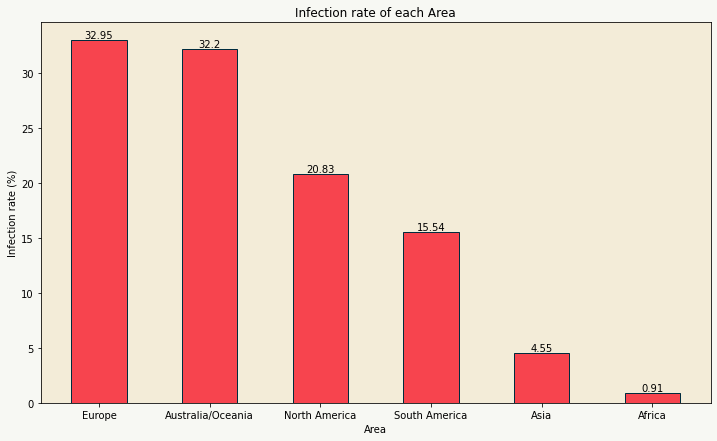

In [334]:
fig = plt.figure(figsize=(12,7))
fig.set_facecolor(fc)
ax = plt.axes()
ax.set_facecolor(bg)

bars = plt.bar(areas_name, infection_rate, width=0.5, color=c1, edgecolor=ec)
plt.bar_label(bars);
plt.xlabel('Area')
plt.ylabel('Infection rate (%)')
plt.title('Infection rate of each Area');

- Nhận xét:
	
    - Xét biểu đồ tỉ lệ số ca nhiễm theo khu vực vào ngày 01/03/2023, châu Âu chiếm tỉ trọng cao nhất (36.22%), tiếp theo đó là châu Á với 31.52%; châu Đại Dương và châu Phi là 2 khu vực có tỉ trọng số ca nhiễm thấp nhất với chỉ lần lượt là 2.06% và 1.88%.
	- Xét biểu đồ tỉ lệ dân số theo khu vực vào ngày 01/03/2023, ta thấy châu Á đứng đầu tiền với tỉ trọng lên đến 59.3%, trong khi khu vực có tỉ trọng số ca nhiễm cao nhất lại có tỉ trọng dân số tương đối thấp (9.409%) và chỉ xếp thứ 3.
	- Qua 2 nhận xét trên, 1 điều có thể thấy là tuy tỉ lệ số ca nhiễm ở châu  u cao nhưng tỉ lệ dân số quá thấp đã dẫn đến việc tỉ lệ nhiễm bệnh trên đầu người ở khu vực này rất cao (chiếm đến 32.95%), trong khi điều ngược lại có thể nhận ra đối với châu Á khi mà vùng này có tỉ lệ dân số quá cao so với thế giới dẫn tới việc tỉ lệ nhiễm bệnh của khu vực này tương đối thấp (chỉ rơi vào khoảng 4.55%).
	
        → Từ những nhận định sơ bộ vừa rồi, ta có thể rút ra được rằng không thể chỉ dựa vào tỉ lệ số ca nhiễm của 1 khu vực mà đánh giá tình trạng dịch ở khu vực đó được. Đôi khi chỉ cần thay đổi góc nhìn 1 chút, nhìn rộng ra 1 tí, cụ thể là xem xét về tỉ lệ nhiễm bệnh trên đầu người, ta có thể thấy tình trạng dịch bệnh của từng khu vực 1 cách thấu đáo hơn và khách quan hơn.


---

### **6.5. Số ca mắc mới, ca chết mới và ca hồi phục mới qua từng ngày của 3 nước Nhật Bản, Nga, và Đài Loan từ ngày 01/03/2023 đến ngày 07/03/2023** <a name = "section6_5"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

In [335]:
df1 = pd.read_csv('datasets/01-03-2023.csv')
df1 = df1[(df1.Country=="Japan") | (df1.Country=="Taiwan") | (df1.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df2 = pd.read_csv('datasets/02-03-2023.csv')
df2 = df2[(df2.Country=="Japan") | (df2.Country=="Taiwan") | (df2.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df3 = pd.read_csv('datasets/03-03-2023.csv')
df3 = df3[(df3.Country=="Japan") | (df3.Country=="Taiwan") | (df3.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df4 = pd.read_csv('datasets/04-03-2023.csv')
df4 = df4[(df4.Country=="Japan") | (df4.Country=="Taiwan") | (df4.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df5 = pd.read_csv('datasets/05-03-2023.csv')
df5 =df5[(df5.Country=="Japan") | (df5.Country=="Taiwan") | (df5.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df6 = pd.read_csv('datasets/06-03-2023.csv')
df6 = df6[(df6.Country=="Japan") | (df6.Country=="Taiwan") | (df6.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

df7 = pd.read_csv('datasets/07-03-2023.csv')
df7 = df7[(df7.Country=="Japan") | (df7.Country=="Taiwan") | (df7.Country=="Russia")][['Country','New_cases','New_recovered','New_Deaths']].reset_index()

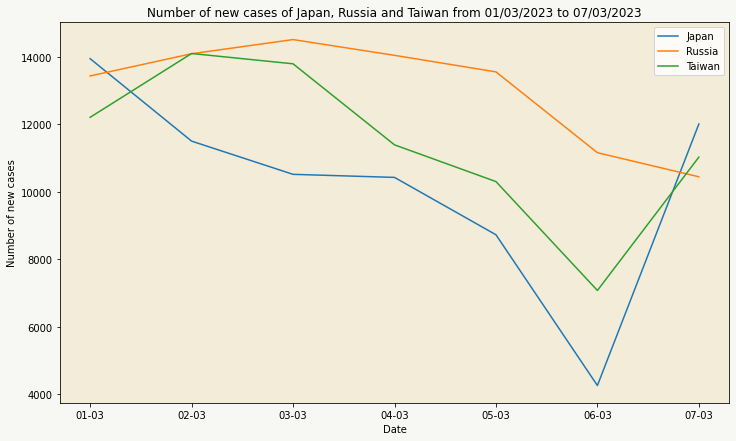

In [336]:
date = ['01-03','02-03','03-03','04-03','05-03','06-03','07-03']
jp_newcases = [df1['New_cases'].loc[0], df2['New_cases'].loc[0], df3['New_cases'].loc[0],
               df4['New_cases'].loc[0], df5['New_cases'].loc[0], df6['New_cases'].loc[0], df7['New_cases'].loc[0]]
rs_newcases = [df1['New_cases'].loc[1], df2['New_cases'].loc[1], df3['New_cases'].loc[1],
               df4['New_cases'].loc[1], df5['New_cases'].loc[1], df6['New_cases'].loc[1], df7['New_cases'].loc[1]]
tw_newcases = [df1['New_cases'].loc[2], df2['New_cases'].loc[2], df3['New_cases'].loc[2],
               df4['New_cases'].loc[2], df5['New_cases'].loc[2], df6['New_cases'].loc[2], df7['New_cases'].loc[2]]

fig, ax = plt.subplots(figsize=(12, 7))
fig.set_facecolor(fc)
ax.plot(date, jp_newcases, label="Japan")
ax.plot(date, rs_newcases, label="Russia")
ax.plot(date, tw_newcases, label="Taiwan")

ax.set_facecolor(bg)
ax.legend()
ax.set_title('Number of new cases of Japan, Russia and Taiwan from 01/03/2023 to 07/03/2023')
ax.set_xlabel('Date')
ax.set_ylabel('Number of new cases');

- Nhận xét:

    - Số ca nhiễm mới của ba nước ( từ ngày 1/3/2023 đến 7/3/2023) biến động theo thời gian.
    - Ở Nhật Bản, từ ngày 1/3/2023 đến ngày 6/3/2023, số ca nhiễm mới có xu hướng giảm ( khoảng từ 14000 ca xuống còn khoảng 4500 ca) và tăng lại sau ngày 6/3/2023 ( lên đến khoảng 12000 ca).
    - Ở Nga, từ ngày 1/3/2023 đến ngày 3/3/2023, số ca nhiễm mới có xu hướng tăng nhẹ ( từ khoảng 13500 ca đến hơn khoảng 14500 ca) và giảm dần đến ngày 7/3/2023 ( giảm dần về 11000 ca).
    - Ở Đài Loan, trong 24 giờ từ ngày 1/3/2023, số ca nhiễm có xu hướng thay đổi theo chiều tăng dần ( từ 12000 ca đến 14000 ca), giảm dần đến ngày 6/3/2023 ( từ 14000 ca giảm dần về 7000 ca) và tăng lại ( tăng đến khoảng 11500 ca).
    - Theo số ca nhiễm giữa 3 nước Đài Loan, Nhật Bản, Nga thì Nhật Bản có số ca nhiễm mới cao nhất vào ngày 1/3/2023 ( khoảng 14000 ca so với Đài Loan là hơn 12000 ca và Nga hơn 13500 ca ) và vào ngày 7/3/2023 ( khoảng  hơn 12000 ca so với Đài Loan là hơn 11500 ca và Nga gần 11500 ca ).


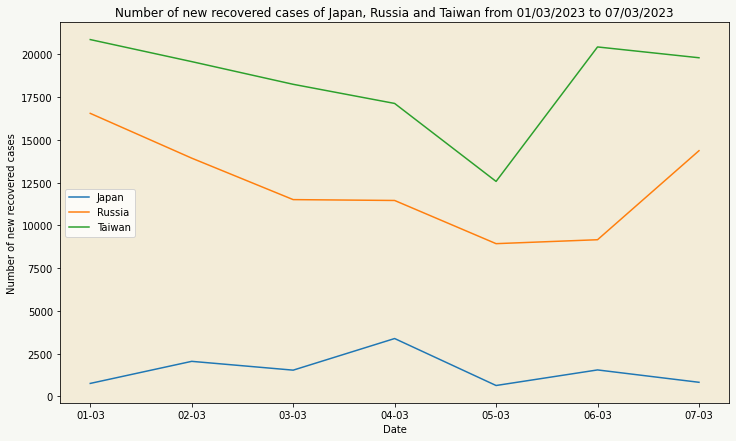

In [337]:
jp_newrcv = [df1['New_recovered'].loc[0], df2['New_recovered'].loc[0], df3['New_recovered'].loc[0],
             df4['New_recovered'].loc[0], df5['New_recovered'].loc[0], df6['New_recovered'].loc[0], df7['New_recovered'].loc[0]]
rs_newrcv = [df1['New_recovered'].loc[1], df2['New_recovered'].loc[1], df3['New_recovered'].loc[1],
             df4['New_recovered'].loc[1], df5['New_recovered'].loc[1], df6['New_recovered'].loc[1], df7['New_recovered'].loc[1]]
tw_newrcv = [df1['New_recovered'].loc[2], df2['New_recovered'].loc[2], df3['New_recovered'].loc[2],
             df4['New_recovered'].loc[2], df5['New_recovered'].loc[2], df6['New_recovered'].loc[2], df7['New_recovered'].loc[2]]

fig, ax = plt.subplots(figsize=(12, 7))
fig.set_facecolor(fc)
ax.plot(date, jp_newrcv, label="Japan")
ax.plot(date, rs_newrcv, label="Russia")
ax.plot(date, tw_newrcv, label="Taiwan")

ax.set_facecolor(bg)
ax.legend()
ax.set_title('Number of new recovered cases of Japan, Russia and Taiwan from 01/03/2023 to 07/03/2023')
ax.set_xlabel('Date')
ax.set_ylabel('Number of new recovered cases');

- Nhận xét:

    - Số ca hồi phục của ba nước ( từ ngày 1/3/2023 đến 7/3/2023) dao động nhẹ.
    - Ở Nhật Bản, từ ngày 1/3/2023 đến ngày 7/3/2023, số ca hồi phục thay đổi nhẹ và tăng lên cao nhất vào ngày 4/3/2023 ( từ khoảng 1200 ca tăng đến hơn 3000 ca).  
    - Ở Nga, từ ngày 1/3/2023 đến ngày 6/3/2023, số ca hồi phục có xu hướng giảm ( từ khoảng hơn 16250 ca giảm về còn khoảng 9000 ca) và tăng đến ngày 7/3/2023 ( lên 15000 ca).
    - Ở Đài Loan, số ca hồi phục có xu hướng giảm mạnh từ ngày 1/3/2023 đến ngày 5/3/2023 ( từ hơn 21000 ca giảm về còn 13500 ca) và tăng mạnh trở lại ( lên đến 21000 ca).
    - Theo số liệu giữa 3 nước Đài Loan, Nhật Bản, Nga thì Đài Loan có số ca hồi phục nhiều nhất ( cao nhất khoảng 21000 ca và thấp nhất khoảng 13500 ca), tiếp theo đó là Nga ( cao nhất khoảng 17000 ca và thấp nhất vào khoảng dưới 9000 ca) và cuối cùng là Nhật Bản ( cao nhất khoảng 3000 ca và thấp nhất khoảng 1200 ca).


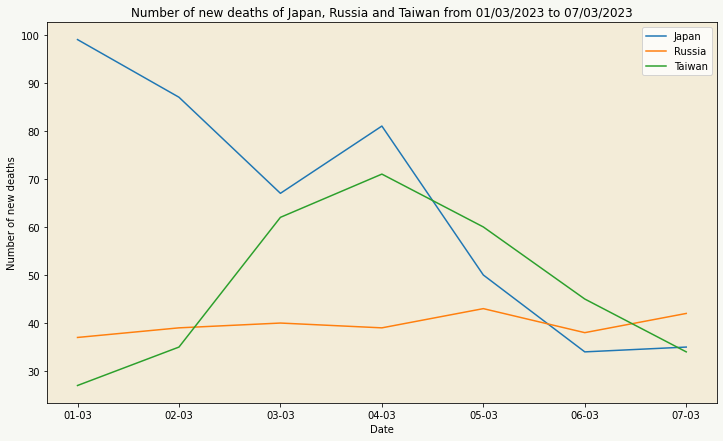

In [338]:
jp_newdeaths = [df1['New_Deaths'].loc[0], df2['New_Deaths'].loc[0], df3['New_Deaths'].loc[0],
                df4['New_Deaths'].loc[0], df5['New_Deaths'].loc[0], df6['New_Deaths'].loc[0], df7['New_Deaths'].loc[0]]
rs_newdeaths = [df1['New_Deaths'].loc[1], df2['New_Deaths'].loc[1], df3['New_Deaths'].loc[1],
                df4['New_Deaths'].loc[1], df5['New_Deaths'].loc[1], df6['New_Deaths'].loc[1], df7['New_Deaths'].loc[1]]
tw_newdeaths = [df1['New_Deaths'].loc[2], df2['New_Deaths'].loc[2], df3['New_Deaths'].loc[2],
                df4['New_Deaths'].loc[2], df5['New_Deaths'].loc[2], df6['New_Deaths'].loc[2], df7['New_Deaths'].loc[2]]

fig, ax = plt.subplots(figsize=(12, 7))
fig.set_facecolor(fc)
ax.plot(date, jp_newdeaths, label="Japan")
ax.plot(date, rs_newdeaths, label="Russia")
ax.plot(date, tw_newdeaths, label="Taiwan")

ax.set_facecolor(bg)
ax.legend()
ax.set_title('Number of new deaths of Japan, Russia and Taiwan from 01/03/2023 to 07/03/2023')
ax.set_xlabel('Date')
ax.set_ylabel('Number of new deaths');

- Nhận xét:

    - Số ca tử vong mới của ba nước ( từ ngày 1/3/2023 đến 7/3/2023) có sự biến động mạnh ở 2 nước Nhật Bản với Đài Loan trong khi Nga chỉ dao động nhẹ.
    - Ở Nhật Bản, từ ngày 1/3/2023 đến ngày 7/3/2023, số ca tử vong giảm mạnh ( từ 100 ca giảm về còn khoảng 35 ca).  
    - Ở Nga, từ ngày 1/3/2023 đến ngày 7/3/2023, số ca tử vong không có nhiều biến đổi ( dao động trong khoảng 35 đến hơn 40 ca).
    - Ở Đài Loan, số ca tử vong tăng từ 1/3/2023 đến 4/3/2023 ( từ dưới 30 ca đến gần 70 ca) và giảm dần đến ngày 7/3/2023 ( xuống còn khoảng 35 ca).
    - Theo số liệu giữa 3 nước Đài Loan, Nhật Bản, Nga thì Nga có xu hướng ổn định nhất ( chỉ trong khoảng 35 đến 45 ca), tiếp đó là Nhật Bản với chiều hướng giảm dần ( chỉ tăng lại vào ngày 3/3/2023 sau đó tiếp tục giảm) và Đài Loan là nước thay đổi thiếu ổn định nhất ( ngày 1/3/2023 và ngày 7/3/2023 là thấp nhất trong 3 nước nhưng khoảng từ 2/3/2023 đến 6/3/2023 thì lại dao động không đều).


- Kết luận:

    - Nhìn chung, số ca nhiễm mới của Nhật Bản tương đối nhiều, nhưng số ca hồi phục lại thấp hơn so với Nga và Đài Loan và không có chiều hướng tăng, điều này cho thấy tình hình dịch bệnh ở Nhật Bản vẫn chưa được kiểm soát tốt
    - Trong khi Nga và Đài Loan tuy số ca nhiễm mới nhiều, nhưng số ca hồi phục tương đối cao và ổn định, số ca tử vong vẫn được kiểm soát và chiếm thiểu số ( trung bình chiếm 0,005% ở Đài Loan và 0,0027% ở Nga), điều này cho thấy tình hình dịch bệnh ở 2 nước Nga và Đài Loan được kiểm soát khá tốt.
    - Ngoài ra các yếu tố tác động khác dẫn đến việc hồi phục và tử vong vẫn khiến việc biểu đồ thể hiện chưa chính xác hoàn toàn( tuổi tác, bệnh nền,…)


---

### **6.6. Tỉ lệ giữa số ca chết, số ca hồi phục và số ca đang nhiễm bệnh trên tổng số ca của các vùng trên thế giới vào ngày 01/03/2023** <a name = "section6_6"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

Vì `Total_cases` bằng tổng `Total_deaths`, `Total_recovered`, `Active_cases`. Do đó, để trả lời câu hỏi này, bằng cách ở mỗi khu vực `Area`, lấy tổng 'Total_cases', 'Total_deaths', 'Total_recovered', 'Active_cases' sau đó dùng stacked bar chart để mô tả dữ liệu

Trước tiên hãy xem qua dữ liệu ban đầu

In [339]:
cv_df.head()

,Country,Total_cases,New_cases,Total_deaths,New_Deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases/1Mpop,Deaths/1Mpop,Total_tests,Tests/1Mpop,Population,Area
0,USA,105285347,NaN,1145661.0,NaN,102682399.0,NaN,1457287.0,2533.0,314467.0,3422.0,1.166932e+09,3485405.0,3.348053e+08,North America
1,India,44686611,NaN,530772.0,NaN,44153504.0,NaN,2335.0,NaN,31769.0,377.0,9.186799e+08,653106.0,1.406632e+09,Asia
2,France,39622231,NaN,164963.0,NaN,39387145.0,NaN,70123.0,869.0,604140.0,2515.0,2.714902e+08,4139547.0,6.558452e+07,Europe
3,Germany,38168908,NaN,168086.0,NaN,37715700.0,16500.0,285122.0,NaN,455022.0,2004.0,1.223324e+08,1458359.0,8.388360e+07,Europe
4,Brazil,37052936,NaN,699087.0,NaN,36235329.0,NaN,118520.0,NaN,172056.0,3246.0,6.377617e+07,296146.0,2.153536e+08,South America


Ở một số quốc gia, chỉ có dữ liệu về `Total_cases` và không có các dữ liệu còn lại. Hãy cùng xem qua các quốc gia đó

In [340]:
df_nan = cv_df.loc[(cv_df['Total_deaths'] + cv_df['Total_recovered'] + cv_df['Active_cases']) != cv_df['Total_cases']]
df_nan.head()

,Country,Total_cases,New_cases,Total_deaths,New_Deaths,Total_recovered,New_recovered,Active_cases,Serious_critical,Cases/1Mpop,Deaths/1Mpop,Total_tests,Tests/1Mpop,Population,Area
10,Turkey,17042722,NaN,101492.0,NaN,NaN,NaN,NaN,NaN,199186.0,1186.0,162743369.0,1902052.0,85561976.0,Asia
65,Tunisia,1150962,NaN,29331.0,NaN,NaN,NaN,NaN,44.0,95542.0,2435.0,5002248.0,415240.0,12046656.0,Africa
77,Paraguay,808327,NaN,19870.0,NaN,NaN,NaN,NaN,7.0,110641.0,2720.0,2657506.0,363751.0,7305843.0,South America
94,Honduras,472116,NaN,11111.0,NaN,NaN,NaN,NaN,105.0,46190.0,1087.0,1633222.0,159787.0,10221247.0,North America
111,Martinique,229807,NaN,1098.0,NaN,NaN,NaN,NaN,12.0,614314.0,2935.0,828928.0,2215870.0,374087.0,North America


Để xử lý các giá trị thiếu này bằng cách, khi group các `Area` và tính tổng của `Total_cases`, `Total_deaths`, `Total_recovered`, `Active_cases`, sau đó lấy hiệu của `Total_cases` với các thuộc tính còn lại sẽ được thuộc tính `Not_recored`. Đây chính là số lượng dữ liệu không được ghi nhận lại ở mỗi châu lục

In [341]:
# group by 'Area' and then get sum of 'Total_cases','Total_deaths', 'Total_recovered', 'Active_cases' in each area
df_groupby_area = cv_df.groupby('Area')[['Total_cases','Total_deaths', 'Total_recovered', 'Active_cases']].sum()
# specify data was not recorded
df_groupby_area['Not_recorded'] = df_groupby_area['Total_cases'] - df_groupby_area[['Total_deaths', 'Total_recovered', 'Active_cases']].sum(axis = 1)
df_groupby_area

,Total_cases,Total_deaths,Total_recovered,Active_cases,Not_recorded
Area,,,,,
Africa,12794281,258582.0,10957200.0,365441.0,1213058.0
Asia,214353455,1536768.0,182194883.0,13463317.0,17158487.0
Australia/Oceania,13996296,26116.0,13777285.0,67554.0,125341.0
Europe,246314132,2017091.0,241805757.0,2209898.0,281386.0
North America,124590104,1611388.0,119679974.0,2395512.0,903230.0
Other,721,15.0,706.0,0.0,0.0
South America,68008352,1350611.0,65524747.0,263710.0,869284.0


Sau khi phân tích, ta có thể thấy rõ tổng số ca nhiễm (`Total_cases`), số ca tử vong (`Total_deaths`), số ca đã được cứu chữa (`Total_recovered`), số ca đang điều trị (`Active_cases`), và các số liệu không được ghi nhận ở mỗi châu lục (`Not_recorded`)

Để phục vụ cho việc trực quan hoá dữ liệu, ta cần chỉnh sửa data frame lại một chút. Vì Area "Other" có số ca nhiễm nhỏ hơn rất nhiều so với các khu vực khác nên sẽ không được trực quan dưới đây

In [342]:
#data frame for stacked bar chart
df_stacked_bar_chart = df_groupby_area[['Total_recovered', 'Active_cases', 'Total_deaths', 'Not_recorded']].sort_values(['Total_recovered'])
df_stacked_bar_chart['Area'] = df_stacked_bar_chart.index
df_stacked_bar_chart = df_stacked_bar_chart.drop('Other')
df_stacked_bar_chart

,Total_recovered,Active_cases,Total_deaths,Not_recorded,Area
Area,,,,,
Africa,10957200.0,365441.0,258582.0,1213058.0,Africa
Australia/Oceania,13777285.0,67554.0,26116.0,125341.0,Australia/Oceania
South America,65524747.0,263710.0,1350611.0,869284.0,South America
North America,119679974.0,2395512.0,1611388.0,903230.0,North America
Asia,182194883.0,13463317.0,1536768.0,17158487.0,Asia
Europe,241805757.0,2209898.0,2017091.0,281386.0,Europe


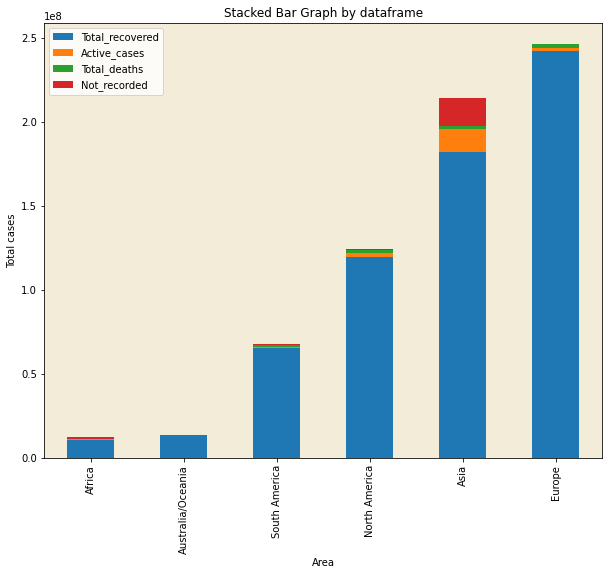

In [343]:
# stacked bar chart
# Due to the very small of total cases in "Other" area, i decided not to visualize it
ax = df_stacked_bar_chart.plot(x='Area', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe', ylabel= "Total cases", figsize=(10, 8))
ax.set_facecolor(bg);

- Nhận xét:

    - Châu Âu (Europe) là khu vực có nhiều ca nhiễm nhất, trong khi Châu Đại Dương là khu vực có ít ca nhiễm nhất.
    - Châu Á có tỉ trọng số ca nhiễm không được ghi nhận lại và số ca nhiễm đang điều trị trên tổng số ca là lớn nhất và châu Âu là nhỏ nhất

Biểu đồ trên chỉ cho thấy được tổng số ca nhiễm và tỉ trọng tình trạng nhiễm bệnh trên tổng số ca nhiễm của các châu lục là nhiều hay ít, nhưng vẫn khó thể trả lời cho câu hỏi liệu so với các khu vực có số lượng nhiễm bệnh ít thì tỉ lệ chữa khỏi bệnh của các quốc gia có nhiều ca nhiễm là cao hay thấp hơn, ti lệ người tử vong là cao hay thấp hơn,... Do đó, cần tìm tỉ lệ tình trạng nhiễm bệnh của các khu vực để làm rõ vấn đề này

In [344]:
#data frame for 100% stacked bar chart
df_100_stacked_bar_chart = df_groupby_area[['Total_recovered', 'Active_cases', 'Total_deaths', 'Not_recorded']].div(df_groupby_area['Total_cases'], axis=0).sort_values(['Total_recovered'])
df_100_stacked_bar_chart['Area'] = df_100_stacked_bar_chart.index
df_100_stacked_bar_chart = df_100_stacked_bar_chart.drop('Other')
df_100_stacked_bar_chart

,Total_recovered,Active_cases,Total_deaths,Not_recorded,Area
Area,,,,,
Asia,0.849974,0.062809,0.007169,0.080048,Asia
Africa,0.856414,0.028563,0.020211,0.094813,Africa
North America,0.960590,0.019227,0.012934,0.007250,North America
South America,0.963481,0.003878,0.019859,0.012782,South America
Europe,0.981697,0.008972,0.008189,0.001142,Europe
Australia/Oceania,0.984352,0.004827,0.001866,0.008955,Australia/Oceania


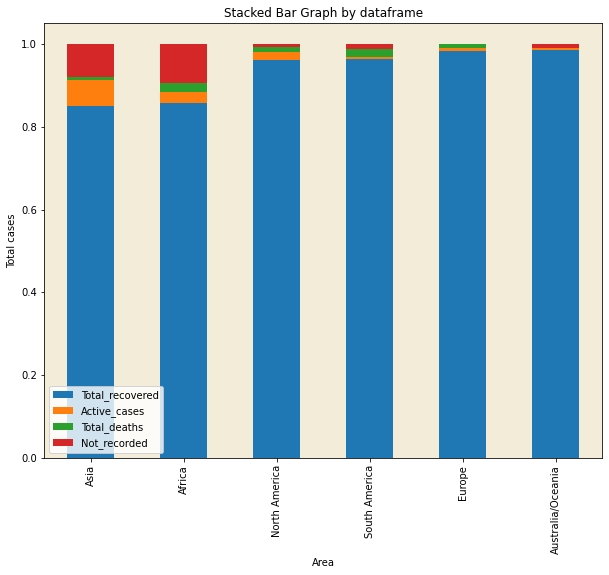

In [345]:
ax = df_100_stacked_bar_chart.plot(x='Area', kind='bar', stacked=True, title='Stacked Bar Graph by dataframe', ylabel= "Total cases", figsize=(10, 8))
ax.set_facecolor(bg);

- Nhận xét:

    - Châu Đại Dương có tỉ lệ cao nhất về Total_recovered trên Total_cases, trong khi Châu Á thấp nhất.
    - Châu Á có tỉ lệ cao nhất về Active_cases trên Total_cases, trong khi Châu Đại Dương và Nam Mỹ có tỉ lệ thấp nhất.
    - So với các châu lục, Nam Mỹ và Châu Phi là 2 khu vực có tỉ lệ ca tử vong nhiều nhất. Và Châu Đại Dương là khu vực có ít ca tử vong nhất.
    - Tỉ lệ các số liệu không được ghi nhận nhiều nhất ở khu vực châu Á và châu Phi và ít nhất ở châu Âu.

- Kết luận:

    1. Qua hai biểu đồ trên, ta có thể thấy rằng thật dễ hiểu khi Châu Đại Dương là một trong số những nơi có ít ca nhiễm nhất nên tỉ lệ được phục hồi cao. Tuy nhiên Châu Phi cũng nằm trong số các châu lục có ít ca nhiễm nhưng lại là nơi có tỉ lệ số ca tử vong nhiều nhất và thấp hơn các khu vực như châu Âu. Hơn nữa tỉ lệ thông tin không được ghi lại là rất cao.
    2. Ngược lại, châu Âu là khu vực có nhiều ca nhiễm nhất, nhưng tỉ lệ phục hồi lại rất cao, đồng thời tỉ lệ tử vong cũng rất thấp.

    → Qua hai điều trên ta có thể phỏng đoán ở các quốc gia phát triển thì cơ sở vật chất, thông tin truyền thông, y tế được trang bị đầy đủ hơn trong khi đó ở các quốc gia đang phát triển thì không được đáp ứng đầy đủ nên dẫn đến hệ quả trên.

---

# **7. Tài liệu tham khảo** <a name = "section7"></a>
<div style="text-align: right"

[Quay về mục lục](#TOC)

- [Stacked bar chart](https://www.geeksforgeeks.org/create-a-stacked-bar-plot-in-matplotlib/)

- [Choropleth graph](https://stackoverflow.com/questions/67367051/plotly-px-choropleth-not-drawing-data-from-json-file)

- [Pie chart](https://www.w3schools.com/python/matplotlib_pie_charts.asp)

- [Line chart](https://www.w3schools.com/python/matplotlib_line.asp)

- [Scatter plot with histograms](https://stackoverflow.com/questions/37008112/matplotlib-plotting-histogram-plot-just-above-scatter-plot)

- [Scatter plot with regression line](https://vimentor.com/vi/lesson/20-su-dung-seaborn-de-ve-cac-bieu-do-thong-ke-phan-2-linear-relationships)

- [Github 1](https://github.com/only2307/Covid19_Scraping_and_Visualize_in_Python)

- [Github 2](https://github.com/khoakoxoan/Covid-analysis)